# Forward modeling

The simplest use of this toolbox is the modeling of the forward problem, that is, given the information on the scatterer dynamics
(Brownian diffusion coefficient `db` and/or mean square velocity `v_ms` depending on the scatterer model) and the geometry (e.g., semi-infinite,
slab, ...) calculate the corresponding autocorrelation functions `g1` and `g2`.

The `forward` module contains the expressions for the normalized and unnormalized first-order autocorrelations `g1_norm` and `g1`
obtained in the framework of the diffusion approximation to the correlation transport equation.
It contains one submodule per geometry: for example, `forward.homogeneous_inf` contains the solution for the homogeneous
semi-infinite geometry, `forward.homogeneous_slab` the ones for the homogeneous laterally infinite slab, and so on.

In addition to a geometric model, we also need a model for scatterer motion. These can be found in `forward.common`, and include
Brownian motion, ballistic motion and hybrid motion with both components.

## Homogeneous semi-infinite geometry
Let's start by generating some autocorrelation curves for the semi-infinite geometry. We start with Brownian motion, considering 6
approximately logarithmically spaced values of `db`.

First of all, let's import the necessary modules.

In [1]:
import src.fit_dcs.forward.common as common             # Scatterer motion model
import src.fit_dcs.forward.homogeneous_semi_inf as hsi  # Geometric model
import numpy as np                          # Array manipulation
import matplotlib.pyplot as plt             # Plotting

The scatterer motion models in `forward.common` take as input the vector of time delays `tau` and the scatterer parameters `db` and/or `v_ms`
and return the mean-square displacement of the scatterers `msd`, a vector the same length as `tau`. **This, not `tau`, is the vector that is
used as an input to the `g1` and `g1_norm` functions** of the `forward` module.

To build our logarithmically spaced `tau` vector, we can simply use the `np.logspace` function. `tau` is expressed in seconds, so we choose
values from 1e-8 to 1e0.

As for the units of the other parameters (e.g., absorption and reduced scattering coefficients `mua` and `musp`, source-detector separation
`rho`, etc.), see the documentation of the various functions. Generally speaking however, `mua` and `musp` are expressed in 1/cm, distances
 such as `rho` in cm and wavelengths in nm.

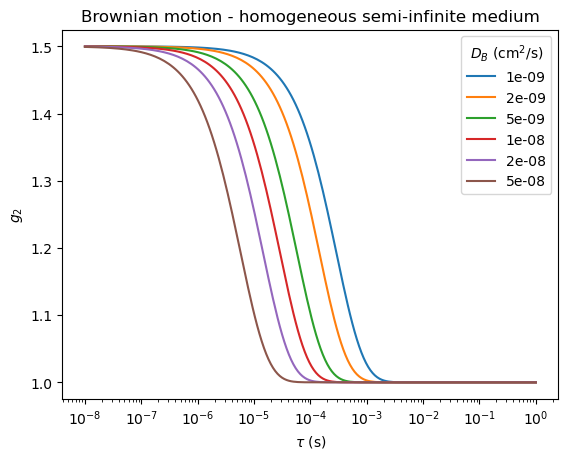

In [2]:
tau = np.logspace(-8, 0, 200)
lambda0 = 785                               # Wavelength, nm
mua = 0.1                                   # Absorption coefficient, 1/cm
musp = 10                                   # Reduced scattering coefficient, 1/cm
rho = 2                                     # Source-detector separation, cm
n = 1.4                                     # Refractive index of the medium (external is 1)
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]   # Values of db, cm^2/s
beta = 0.5                                  # Coherence of detected light

# Preallocate g1 array, a 2D matrix whose rows are tau bins and columns are separate autocorrelations.
g1_norm = np.zeros((len(tau), len(db)))

# Generate one curve per db
for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])                           # Compute mean-square displacement
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)    # Compute 1st-order autocorrelation

# Compute 2nd-order autocorrelation
g2_norm = 1 + beta * g1_norm**2

# Plot resulting curves.
plt.semilogx(tau, g2_norm)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$g_2$')
plt.legend(db, title=r"$D_B$ (cm$^2$/s)")
plt.title("Brownian motion - homogeneous semi-infinite medium")
plt.show()

We can also try a different model for scatterer motion. Let's try the ballistic one:


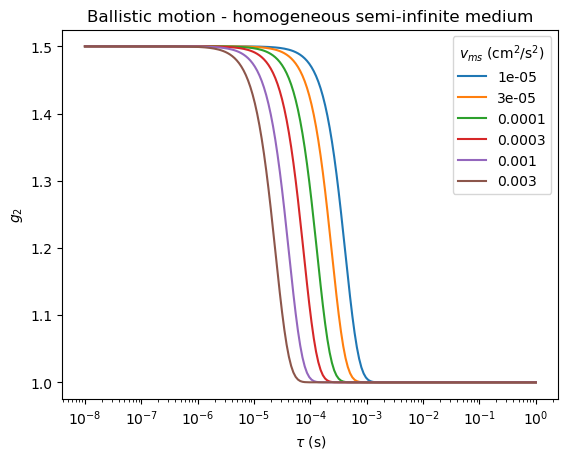

In [7]:
v_ms = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]     # Mean square velocity, cm^2/s^2

# Preallocate g1 array, a 2D matrix whose rows are tau bins and columns are separate autocorrelations.
g1_norm = np.zeros((len(tau), len(v_ms)))

# Generate one curve per v_ms
for i in range(len(v_ms)):
    msd = common.msd_ballistic(tau, v_ms[i])                        # Compute mean-square displacement
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)    # Compute 1st-order autocorrelation

# Compute 2nd-order autocorrelation
g2_norm = 1 + beta * g1_norm**2

# Plot resulting curves.
plt.semilogx(tau, g2_norm)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$g_2$')
plt.legend(v_ms, title=r"$v_{ms}$ (cm$^2$/s$^2$)")
plt.title("Ballistic motion - homogeneous semi-infinite medium")
plt.show()

Finally, the hybrid one:

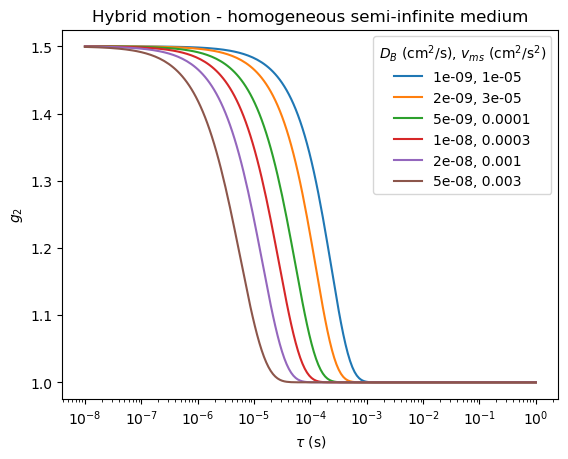

In [8]:
# Preallocate g1 array, a 2D matrix whose rows are tau bins and columns are separate autocorrelations.
g1_norm = np.zeros((len(tau), len(db)))

# Generate one curve per (db, v_ms) pair
for i in range(len(db)):
    msd = common.msd_hybrid(tau, db[i], v_ms[i])                    # Compute mean-square displacement
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)    # Compute 1st-order autocorrelation

# Compute 2nd-order autocorrelation
g2_norm = 1 + beta * g1_norm**2

# Plot resulting curves.
plt.semilogx(tau, g2_norm)
plt.legend([f"{db[i]}, {v_ms[i]}" for i in range(len(db))], title=r"$D_B$ (cm$^2$/s), $v_{ms}$ (cm$^2$/s$^2$)")
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$g_2$')
plt.title("Hybrid motion - homogeneous semi-infinite medium")
plt.show()

## Homogeneous slab - transmittance
Another interesting geometry is the laterally infinite slab, in transmittance configuration. After importing the appropriate module,
forward modeling is as straightforward as the previous case. Do note, however, that for this particular geometry `g1` is obtained as
a truncated sum, with the summation index `m` ranging from `-m_max` to `+m_max`.
Therefore, for this example, we will keep `db` fixed while varying `m_max` to assess convergence.

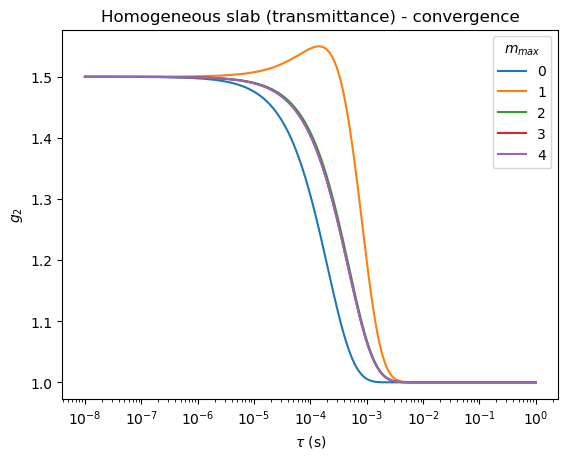

In [9]:
import src.fit_dcs.forward.homogeneous_inf_slab as slab

mua = 0.1                                   # Absorption coefficient, 1/cm
musp = 10                                   # Reduced scattering coefficient, 1/cm
rho = 2                                     # Lateral source-detector separation, cm (for rho=0 source and detection are facing)
db = 1e-9                                   # Brownian diffusion coefficient, cm^2/s
d = 0.5                                     # Slab thickness, cm
m_max = [0, 1, 2, 3, 4]                     # Maximum index of the summation. 2 * m_max + 1 terms are kept.

# Preallocate g1 array, a 2D matrix whose rows are tau bins and columns are separate autocorrelations.
g1_norm = np.zeros((len(tau), len(m_max)))
msd = common.msd_brownian(tau, db)          # Compute mean-square displacement
# Generate one curve per m_max
for i in range(len(m_max)):
    g1_norm[:, i] = slab.g1_transmittance_norm(msd, mua, musp, rho, n, lambda0, d, m_max[i])    # Compute 1st-order autocorrelation

# Compute 2nd-order autocorrelation
g2_norm = 1 + beta * g1_norm**2

# Plot resulting curves.
plt.semilogx(tau, g2_norm)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$g_2$')
plt.legend(m_max, title=r"$m_{max}$")
plt.title("Homogeneous slab (transmittance) - convergence")
plt.show()

## Adding noise
So far all the curves we generated were noiseless, as they were obtained using the analytical solutions to the correlation diffusion equation.
The `utils.noise` module offers noise-related functionalities, most importantly the expression for the standard deviation of `g2_norm` as a
function of time delay `tau`.

This model was obtained for an exponentially decaying `g2_norm`, that is, `g2_norm = 1 + beta * exp(-tau/tau_c)`, which works best at short
time delays.

Let's plot the standard deviation. To get realistic results, we will load the `tau` which comes from a hardware correlator, rather than creating
it ourselves as we did earlier.

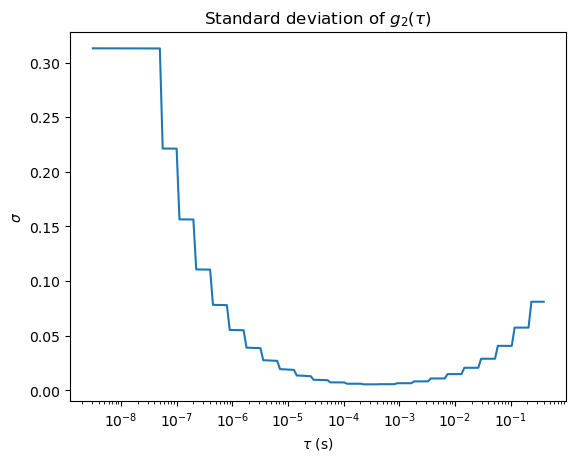

In [10]:

from src.fit_dcs.utils import noise

tau = np.load("data/tau.npz")["tau_hardware"]
t_integration = 1   # Integration time, s
countrate = 70_000  # Measurement countrate, Hz
tau_c = 1e-5        # Exponential decay time constant, s
n_speckle = 1       # Number of speckles detected in parallel
sigma = noise.sigma_g2_norm(tau, t_integration, countrate, beta, tau_c, n_speckle)
plt.semilogx(tau, sigma)
plt.xlabel(r"$\tau$ (s)")
plt.ylabel(r"$\sigma$")
plt.title(r"Standard deviation of $g_2 (\tau)$")
plt.show()

We notice two features about this plot:
1. First, the step-like behavior, which stems from the stepped bin width used in the correlator.
2. Second, the non-decreasing trend: while the noise initially decreases with `tau`, it later increases again starting from about 1 ms.
This behavior is inconsistent with experimental observations, which show a decreasing trend over the whole time delay range.
This failure of the noise model at high delays has been previously observed in the scientific literature.

Depending on our application, we might want to modify the output of this function, for example by manually setting `sigma`
at the late bins to its minimum value to ensure a decreasing trend:

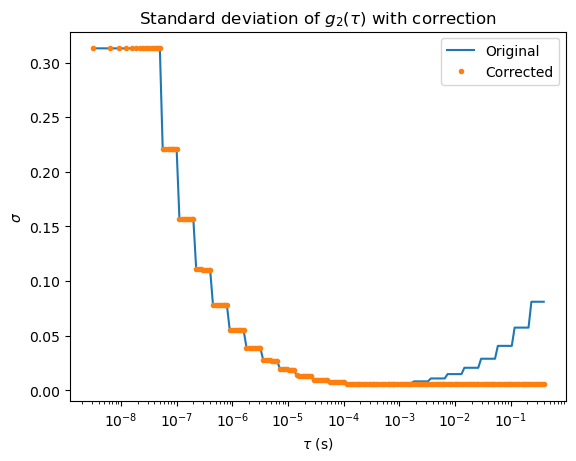

In [12]:
idx_last_good = np.argmin(sigma)
sigma_corrected = sigma.copy()
sigma_corrected[idx_last_good + 1:] = sigma_corrected[idx_last_good]
plt.semilogx(tau, sigma, label="Original")
plt.semilogx(tau, sigma_corrected, linestyle="", marker=".", label="Corrected")
plt.xlabel(r"$\tau$ (s)")
plt.ylabel(r"$\sigma$")
plt.legend()
plt.title(r"Standard deviation of $g_2 (\tau)$ with correction")
plt.show()

Now that we have the noise model, we can use it to add noise to our autocorrelation curves to mimic a real measurement. To do this, we
can sample from a Gaussian distribution with mean `g2_norm` and standard deviation `sigma`.

Remember that the `sigma_g2_norm` function takes as input `tau_c`, the time constant of the exponential decay. To estimate this, the
`g2_norm` curve should be fitted with the exponential function defined above.

While we could do this process manually, the `noise` module provides a `NoiseAdder` class that automates this process. It takes as input a
`g2_norm` matrix (rows are time bins, columns are separate iterations), the corresponding `tau` vector, as well as the measurement conditions
(i.e., integration time, countrate, etc.) and does precisely what we just described: it fits the autocorrelation to determine `tau_c`, calculates
the standard deviation `sigma`, and samples from a Gaussian distribution to find the noisy `g2_norm_noisy`.
Additional inputs are `tau_lim`, the upper tau limit for fitting `g2_norm` to find `tau_c`, and the boolean `ensure_decreasing`, which
controls whether to apply the aforementioned correction to `sigma` before sampling the noise.

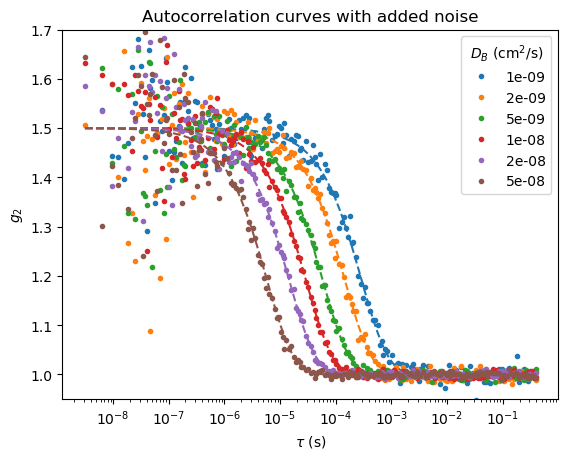

In [14]:
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]  # Values of db, cm^2/s
# Preallocate g1 array, a 2D matrix whose rows are tau bins and columns are separate autocorrelations.
g1_norm = np.zeros((len(tau), len(db)))
# Generate one curve per db
for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])  # Compute mean-square displacement
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)  # Compute 1st-order autocorrelation

# Compute 2nd-order autocorrelation
g2_norm = 1 + beta * g1_norm ** 2

# Add noise
noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm,
    tau=tau,
    t_integration=1,
    countrate=150_000,
    beta=beta,
    n_speckle=1,
    tau_lim=1.56e-5,
    ensure_decreasing=True
)
g2_norm_noisy = noise_adder.add_noise()

# Plot resulting curves
for i in range(len(db)):
    plt.semilogx(tau, g2_norm[:, i], linestyle='--', color=f"C{i}")
    plt.semilogx(tau, g2_norm_noisy[:, i], linestyle='none', marker='.', color=f"C{i}", label=db[i])

plt.xlabel(r"$\tau$ (s)")
plt.ylabel(r"$g_2$")
plt.ylim((0.95, 1 + beta + 0.2))
plt.title("Autocorrelation curves with added noise")
plt.legend(title=r"$D_B$ (cm$^2$/s)")
plt.show()